## Matrix factorization for recommendation problems

In this notebook I'd like to consider a simpler architecture for solving the same problem: **Matrix factorization**, and simpler can be a very good thing! Sometimes a simple model will converge quickly to an adequate solution, where a more complicated model might overfit or fail to converge.
Here's what our matrix factorization model will look like:
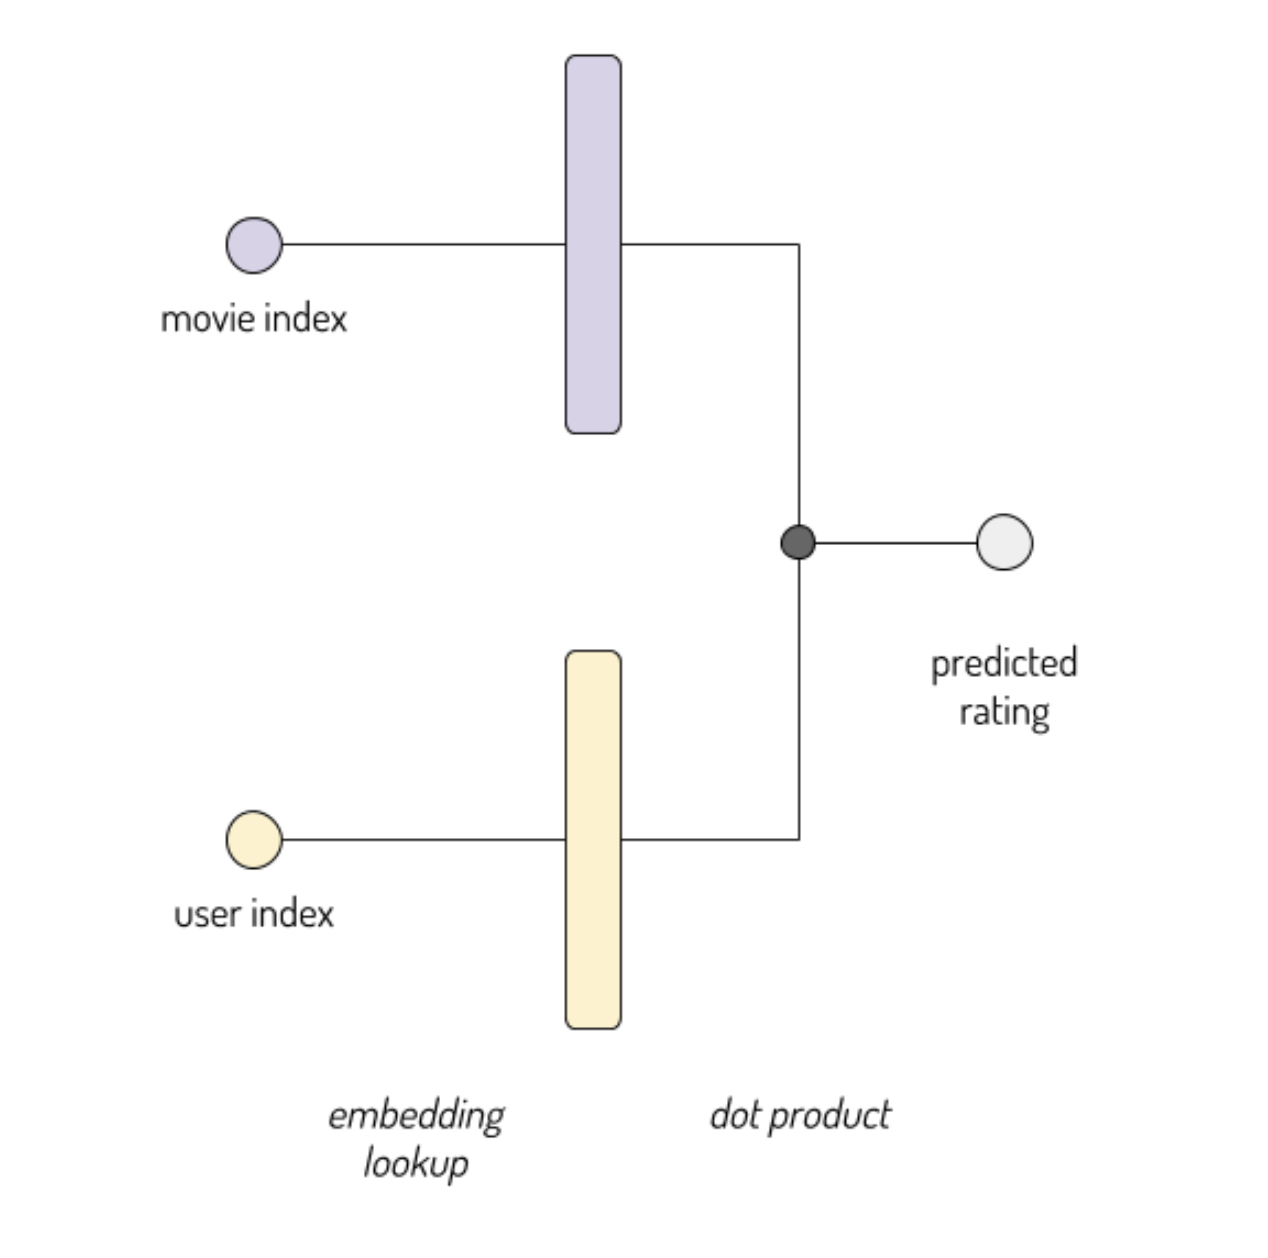

#### Dot Products

The dot product of two length n  vectors  a  and  b  is defined as:

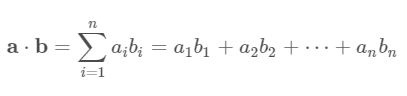

The result is a single scalar number (not a vector).

The dot product is only defined for vectors of the same length. This means we need to use the same size for movie embeddings and user embeddings.

As an example, suppose we've trained embeddings of size 4, and the movie Twister is represented by the vector:

**M_Twister = [1.0 -0.5 0.3 -0.1]**

And the user Stanley is represented by:

**U_Stanley = [-0.2 1.5 -0.1 0.9]**

What rating do we think Stanley will give to Twister? We can calculate our model's output as:

**M_Twister.U_Stanley = (1.0.-0.2) + (-0.5.1.5) + (0.3.-0.1) + (-0.1.0.9) = -1.07**                


Because we're training on a a centered version of the rating column, our model's output is on a scale where 0 = the overall average rating in the training set (about 3.5). So we predict that Stanley will give Twister  **3.5 + (−1.07) = 2.43  stars.**

#### Why?
There's an intuitive interpretation that supports the decision to combine our embedding vectors in this way. Suppose the dimensions of our movie embedding space correspond to the following axes of variation:

Dimension 1: How action-packed?
Dimension 2: How romantic?
Dimension 3: How mature is the intended audience?
Dimension 4: How funny is it?
Hence, Twister, an action-packed disaster movie, has a positive value of 1.0 for  m1 .

What does this imply about the meaning of our user vectors? Remember that  m1u1  is one of the terms we add up to get our predicted rating. So if  u1  is 1.0, it will increase our predicted rating by 1 star (vs.  u1=0 ). If  u1=.5 , our predicted rating goes up half a star. If  u1  is -1, our predicted rating goes down a star.

In plain terms  u1  tells us 'how does this user feel about action?'. Do they love it? Hate it? Or are they indifferent?

Stanley's vector tells us he's a big fan of romance and comedy, and slightly dislikes action and mature content. What if we give him a movie that's similar to the last one except that it has lots of romance?

**M_Titanic = [1.0 1.1 0.3 -0.1]**

It's not hard to predict how this affects our rating output. We're giving Stanley more of what he likes, so his predicted rating increases.

**predicted_rating(Stanley, Titanic) = M_Titanic.U_Stanley + 3.5 = 4.83 stars**

> Aside: In practice, the meaning of the dimensions of our movie embeddings will not be quite so clear-cut, but it remains true that the meaning of our movie embedding space and user embedding space are fundamentally tied together:  ui  will always represent "how much does this user like movies that have the quality represented by  mi ?". (Hopefully this also gives some more intuition for why the movie embedding space and user embedding space have to be the same size for this technique.)

In [2]:
import os
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

tf.set_random_seed(1); np.random.seed(1); random.seed(1) # Set random seeds for reproducibility

ratings_df = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating', 'y'])
df = ratings_df

movies_df = pd.read_csv('movies.csv')

movies_df.head()

,movieId,title,genres,year,key,n_ratings,mean_rating
0,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,49695,3.921240
1,1,Jumanji,Adventure|Children|Fantasy,1995,Jumanji,22243,3.211977
2,2,Grumpier Old Men,Comedy|Romance,1995,Grumpier Old Men,12735,3.151040
3,3,Waiting to Exhale,Comedy|Drama|Romance,1995,Waiting to Exhale,2756,2.861393
4,4,Father of the Bride Part II,Comedy,1995,Father of the Bride Part II,12161,3.064592


### Coding Matrix factorization architecture for model

The code to create this model is similar to the code we wrote for DNN model, except I combine the outputs of the user and movie embedding layers using a Dot layer (instead of concatenating them, and piling on dense layers).

In [3]:
movie_embedding_size = user_embedding_size = 8

# Each instance consists of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')

user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

dotted = keras.layers.Dot(2)([user_embedded, movie_embedded])
out = keras.layers.Flatten()(dotted)

model_MF = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model_MF.compile(
    tf.train.AdamOptimizer(0.001),
    loss='MSE',
    metrics=['MAE'],
)
model_MF.summary(line_length=88)

________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
user_id (InputLayer)         (None, 1)          0                                       
________________________________________________________________________________________
movie_id (InputLayer)        (None, 1)          0                                       
________________________________________________________________________________________
user_embedding (Embedding)   (None, 1, 8)       1107952   user_id[0][0]                 
________________________________________________________________________________________
movie_embedding (Embedding)  (None, 1, 8)       213952    movie_id[0][0]                
________________________________________________________________________________________
dot (Dot)                    (None, 1, 1)       0         user_embedding[0][0]          
                     

In [4]:
history_mf = model_MF.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5000,
    epochs=20,
    verbose=0,
    validation_split=.05,
);

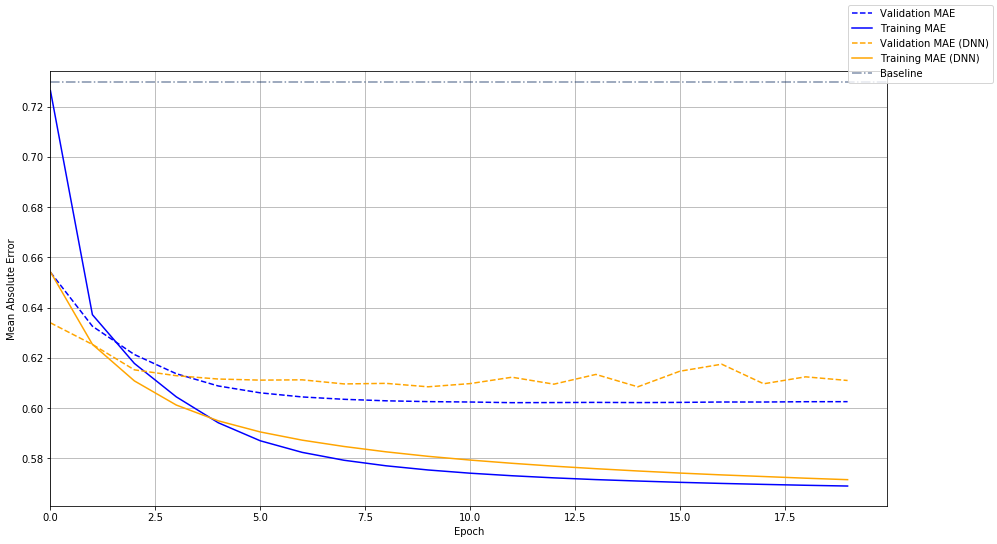

In [5]:
# Load up the training stats we saved to disk in the previous tutorial

hdf = pd.read_csv('history-bias.csv') # DNN model with bias

fig, ax = plt.subplots(figsize=(15, 8))
c1 = 'blue'
ax.plot(history_mf.epoch, history_mf.history['val_mean_absolute_error'], '--', label='Validation MAE', color=c1)
ax.plot(history_mf.epoch, history_mf.history['mean_absolute_error'], label='Training MAE', color=c1)

c2 = 'orange'
ax.plot(hdf.epoch, hdf.val_mae, '--', label='Validation MAE (DNN)', color=c2)
ax.plot(hdf.epoch, hdf.train_mae, label='Training MAE (DNN)', color=c2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0)
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='-.', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

Our new, simpler model Matrix Factorization (in blue) is looking pretty good.

However, even though our embeddings are fairly small, both models suffer from some obvious overfitting. That is, the error on the training set the solid lines is significantly better than on the unseen data. 

I consider that Matrix Factorization architecture(simple model) is better than DNN model in terms of 'validation loss'. 

In the code sections below, we see that using MF model to generate recommendations and fine tune the model to get better results

## Generating Recommendations

In the code sell below it is shown that how our model performs in predicting the ratings a particular user would give to some set of movies.

we calculated predicted ratings for 5 specific movies:

In [77]:
# Id of the user for whom we're predicting ratings
uid = 2556
candidate_movies = movies_df[
    movies_df.title.str.contains('Naked Gun')
    | (movies_df.title == 'The Sisterhood of the Traveling Pants')
    | (movies_df.title == 'Lilo & Stitch')
].copy()

preds = model_MF.predict([
    [uid] * len(candidate_movies), # User ids 
    candidate_movies.index, # Movie ids
])
# Because our model was trained on a 'centered' version of rating (subtracting the mean, so that
# the target variable had mean 0), to get the predicted star rating on the original scale, we need
# to add the mean back in.
row0 = df.iloc[0]
offset = row0.rating - row0.y
candidate_movies['predicted_rating'] = preds + offset
candidate_movies.head()[ ['movieId', 'title', 'predicted_rating'] ]

,movieId,title,predicted_rating
366,366,Naked Gun 33 1/3: The Final Insult,3.295616
3775,3775,The Naked Gun: From the Files of Police Squad!,4.330486
3776,3776,The Naked Gun 2 1/2: The Smell of Fear,3.827621
5347,5347,Lilo & Stitch,4.216752
10138,10138,The Sisterhood of the Traveling Pants,3.189022


Suppose we're interested in the somewhat more open-ended problem of **generating recommendations**. i.e. given some user ID and some number `k`, we need to generate a list of `k` movies we think the user will enjoy.

The most straightforward way to do this would be to calculate the predicted rating this user would assign for *every movie in the dataset*, then take the movies with the `k` highest predictions.

In the code cell below, we define a function to generate top k highest recommendations by given user_id by following steps:
1. Create a list/array containing all movie ids (from the movies dataframe)
2. Call model.predict() on a list/array with repeated copies of uid, and the sequence you created in step 1
3. Add the results of step 2 to the movies df as a new column, "predicted_rating".
4. Sort on the column you added in step 3, and return the top n rows using the head() method.

In [78]:
def recommend(model, user_id, n=5):
    """Return a DataFrame with the n most highly recommended movies for the user with the
    given id. (Where most highly recommended means having the highest predicted ratings 
    according to the given model).
    The returned DataFrame should have a column for movieId and predicted_rating (it may also have
    other columns).
    """
    movie_ids = movies_df.index
    
    preds = model_MF.predict([np.repeat(user_id, len(movie_ids)), movie_ids])
    
    movies_df.loc[movie_ids, 'predicted_rating'] = preds+offset
    
    recc = movies_df.sort_values(by='predicted_rating',ascending = False).head(n)

    return recc


## check the recommendations for particular user

Run the code cell below to get our most highly recommended movies for user #26556.

In [93]:
recommend(model_MF, 26556)

,movieId,title,genres,year,key,n_ratings,mean_rating,predicted_rating
1233,1233,Evil Dead II (Dead by Dawn),Action|Comedy|Fantasy|Horror,1987,Evil Dead II (Dead by Dawn),7788,3.772085,6.419149
2932,2932,Re-Animator,Comedy|Horror|Sci-Fi,1985,Re-Animator,1979,3.476503,6.205729
2374,2374,The Texas Chainsaw Massacre,Horror,1974,"Texas Chainsaw Massacre, The (1974)",3026,3.211335,6.200533
4438,4438,The Return of the Living Dead,Comedy|Horror|Sci-Fi,1985,The Return of the Living Dead,1081,3.369103,6.097945
1213,1213,Dead Alive (Braindead),Comedy|Fantasy|Horror,1992,Dead Alive (Braindead),2576,3.722632,6.045256


Do these recommendations seem sensible? If you'd like a reminder of user 26556's tastes, we can see below to see all their ratings (in descending order).

In [94]:
uid = 26556
user_ratings = df[df.userId==uid]
movie_cols = ['movieId', 'title', 'genres', 'year', 'n_ratings', 'mean_rating']
user_ratings.sort_values(by='rating', ascending=False).merge(movies_df[movie_cols], on='movieId')

,userId,movieId,rating,y,title,genres,year,n_ratings,mean_rating
0,26556,2706,5.0,1.47437,Airplane II: The Sequel,Comedy,1982,4284,3.045868
1,26556,2705,5.0,1.47437,Airplane!,Comedy,1980,18866,3.798261
2,26556,2863,4.5,0.97437,Dr. No,Action|Adventure|Thriller,1962,7183,3.688153
3,26556,2102,4.5,0.97437,Strangers on a Train,Crime|Drama|Film-Noir|Thriller,1951,5154,4.158615
4,26556,2216,4.5,0.97437,History of the World: Part I,Comedy|Musical,1981,4313,3.595177
5,26556,534,4.5,0.97437,Six Degrees of Separation,Drama,1993,5101,3.710449
6,26556,937,4.5,0.97437,Mr. Smith Goes to Washington,Drama,1939,5712,4.032651
7,26556,2286,4.5,0.97437,Fletch,Comedy|Crime|Mystery,1985,6298,3.450857
8,26556,913,4.0,0.47437,Notorious,Film-Noir|Romance|Thriller,1946,4932,4.197790
9,26556,730,4.0,0.47437,Spy Hard,Comedy,1996,6112,2.738138


From the above result, if we review our top-recommended movies. Are they reasonable?
It seems obvious that top k recommended movies are not similar or reasonable to the actual values


I'm going to claim that these recommended movies are bad. In terms of genre and themes, our top picks don't seem like a great fit. But the most notable issue is that our top recommended movies are super-obscure, having only a handful of ratings each across the dataset. We just don't know much about these movies, so how can we be so confident that our target user will like them?

> Aside: You may have noticed another problem, which becomes very obvious when we look at the movies with the highest (or lowest) predicted scores: sometimes our model predicts values outside the allowable range of 0.5-5 stars. For the purposes of recommendation, this is actually no problem: we only care about ranking movies, not about the absolute values of their predicted scores. But this is still an interesting problem to consider. In the following sections we see how could we prevent our model from incurring needless errors by making predictions outside the allowable range.

## How are we going to fix this mess?

How can we improve the problem with our recommendations that we identified in above code cells. This could involve changing our model's structure, our training procedure, or our procedure for generating recommendations given a model.



One simple solution would be limiting our recommendations to movies with at least n ratings. This feels inelegant, in that we have to choose some arbitrary cut-off, and any reasonable choice will probably exclude some good recommendations. It would be nice if we could take into account popularity in a 'smoother' way. On the other hand, this is very simple to implement, and we don't even need to re-train our model, so it's worth a shot.

If we're willing to train a new model, there's another less hacky approach we can take which might fix our obscure recommendation problem and improve our overall accuracy at the same time: regularization. Specifically, putting an L2 weight penalty on our embeddings. We will see how we would implement it in following code sections.

#### Fixing our obscure recommendation problem (thresholding)

The code cell below implements the `recommend_nonobscure` function, which will recommend the best movies which have at least some minimum number of ratings. 


In [81]:
def recommend_nonobscure(model, user_id, n=5, min_ratings=1000):
    """Return a DataFrame with the n movies which the given model assigns the highest 
    predicted ratings for the given user, *limited to movies with at least the given
    threshold of ratings*.
    """
    movie_ids = movies_df[movies_df['n_ratings']>=min_ratings].index
    preds = model.predict([np.repeat(user_id, len(movie_ids)), movie_ids])
    
    movies_df.loc[movie_ids, 'predicted_rating'] = preds+offset
    
    recc = movies_df.loc[movie_ids].sort_values(by = 'predicted_rating', ascending = False).head(n)

    return recc
    


In [82]:
recommend_nonobscure(model_MF, uid)

,movieId,title,genres,year,key,n_ratings,mean_rating,predicted_rating
1233,1233,Evil Dead II (Dead by Dawn),Action|Comedy|Fantasy|Horror,1987,Evil Dead II (Dead by Dawn),7788,3.772085,5.372667
1213,1213,Dead Alive (Braindead),Comedy|Fantasy|Horror,1992,Dead Alive (Braindead),2576,3.722632,5.367653
18811,18811,The Cabin in the Woods,Comedy|Horror|Sci-Fi|Thriller,2012,The Cabin in the Woods,1757,3.672738,5.288554
723,723,Cemetery Man (Dellamorte Dellamore),Horror,1994,Cemetery Man (Dellamorte Dellamore),1122,3.506239,5.274037
1189,1189,Army of Darkness,Action|Adventure|Comedy|Fantasy|Horror,1993,Army of Darkness,12469,3.725319,5.225542


Run the cell below to take a look at our new recommended movies. Did this fix our problem? Do we get better results with a different threshold?

## Introducing L2 regularization to our model


We train our model by minimizing a loss function. In this case, that's the squared difference between our model's predicted rating and the actual rating. L2 regularization adds another term to our model's loss function - a "weight penalty". Now our model must balance making accurate predictions while keeping embedding weights not too big.

We call this a form of regularization, meaning it's expected to reduce overfitting to the training set. 

So here comes a question that is **How? And what does this have to do with our obscure recommendation problem?**

Even if a movie has only a single rating in the dataset, our model will, in the absence of regularization, try to move its embedding around to match that one rating. However, if the model has a budget for movie weights, it's not very efficient to spend it on improving the accuracy of one rating out of 20,000,000. Popular movies will be worth assigning large weights. Obscure movies should have weights close to 0.

>If a movie's embedding vector is all zeros, our model's output will always be zero (regardless of the user embedding vector). 

Recall that an output value of 0 for our model corresponds to a predicted rating equal to the overall average in the training set (around 3.5 stars). This seems like a reasonable behaviour to tend toward for movies we have little information about.



### Fixing our obscure recommendation problem by tuning hyperparameters of our model

>**In the code cell below, we buid and train the model by tuning hyperparameters, The model trained in this code cell is the best performing model I was able to get (on the task of MovieLens rating prediction) after a bit of experimentation with hyperparameters. It uses:**

>>1. matrix factorization architecture
>2. embedding size = 8
>3. embedding L2 penalty
>4. dropout (applied to embedding vectors)

As the model with the best error will probably have the 'best' embeddings, in terms of identifying interesting/useful latent properties.



In [6]:
import keras

movie_embedding_size = user_embedding_size = 8

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')

movie_r12n = keras.regularizers.l1_l2(l1=0, l2=1e-6)
user_r12n = keras.regularizers.l1_l2(l1=0, l2=1e-7)
dropout = .2

# Had good results with 'glorot_uniform' embeddings initializer, but this seems to cause some issues
# with model deserialization
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size,
                                       embeddings_regularizer=user_r12n,
                                       input_length=1, name='user_embedding')(user_id_input)
user_embedded = keras.layers.Dropout(dropout)(user_embedded)

movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        embeddings_regularizer=movie_r12n,
                                        input_length=1, name='movie_embedding')(movie_id_input)
movie_embedded = keras.layers.Dropout(dropout)(movie_embedded)

dotted = keras.layers.Dot(2)([user_embedded, movie_embedded])
out = keras.layers.Flatten()(dotted)

biases = 0
if biases:
    bias_r12n = None
    bias_r12n = keras.regularizers.l1_l2(l1=1e-4, l2=1e-7) # XXX 1e-6 -> 1e-4
    bias_init = 'zeros'
    movie_b = keras.layers.Embedding(df.movieId.max()+1, 1, 
                                             name='movie_bias',
                                             embeddings_initializer=bias_init,
                                             embeddings_regularizer=bias_r12n,
                                            )(movie_id_input)
    movie_b = keras.layers.Flatten()(movie_b)

    user_b = keras.layers.Embedding(df.userId.max()+1, 1, 
                                             name='user_bias',
                                             embeddings_initializer=bias_init,
                                             embeddings_regularizer=bias_r12n,
                                            )(user_id_input)
    user_b = keras.layers.Flatten()(user_b)
    out = keras.layers.Add()([user_b, movie_b, out])

best_model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)

best_model.compile(
    #tf.train.AdamOptimizer(0.001),
    keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
    loss='MSE',
    metrics=['MAE'],
)



Using TensorFlow backend.


In [7]:
tf.set_random_seed(1); np.random.seed(1); random.seed(1)
history_bestmodel = best_model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=10**4,
    epochs=30,
    verbose=2,
    validation_split=.05,
);

Train on 19000249 samples, validate on 1000014 samples
Epoch 1/30
 - 126s - loss: 0.9838 - mean_absolute_error: 0.7788 - val_loss: 0.8226 - val_mean_absolute_error: 0.6971
Epoch 2/30
 - 120s - loss: 0.8054 - mean_absolute_error: 0.6883 - val_loss: 0.7571 - val_mean_absolute_error: 0.6632
Epoch 3/30
 - 123s - loss: 0.7768 - mean_absolute_error: 0.6732 - val_loss: 0.7410 - val_mean_absolute_error: 0.6543
Epoch 4/30
 - 120s - loss: 0.7659 - mean_absolute_error: 0.6673 - val_loss: 0.7319 - val_mean_absolute_error: 0.6494
Epoch 5/30
 - 139s - loss: 0.7590 - mean_absolute_error: 0.6636 - val_loss: 0.7245 - val_mean_absolute_error: 0.6455
Epoch 6/30
 - 304s - loss: 0.7532 - mean_absolute_error: 0.6605 - val_loss: 0.7180 - val_mean_absolute_error: 0.6423
Epoch 7/30
 - 123s - loss: 0.7487 - mean_absolute_error: 0.6583 - val_loss: 0.7125 - val_mean_absolute_error: 0.6396
Epoch 8/30
 - 124s - loss: 0.7447 - mean_absolute_error: 0.6563 - val_loss: 0.7078 - val_mean_absolute_error: 0.6373
Epoch 9/3

In [10]:
history_FS = (15, 5)
def plot_history(histories, keys=('mean_absolute_error',), train=True, figsize=history_FS):
    if isinstance(histories, tf.keras.callbacks.History):
        histories = [ ('', histories) ]
    for key in keys:
        plt.figure(figsize=history_FS)
        for name, history in histories:
            val = plt.plot(history.epoch, history.history['val_'+key],
                           '--', label=str(name).title()+' Val')
            if train:
                plt.plot(history.epoch, history.history[key], color=val[0].get_color(), alpha=.5,
                         label=str(name).title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.title(key)

        plt.xlim([0,max(max(history.epoch) for (_, history) in histories)])

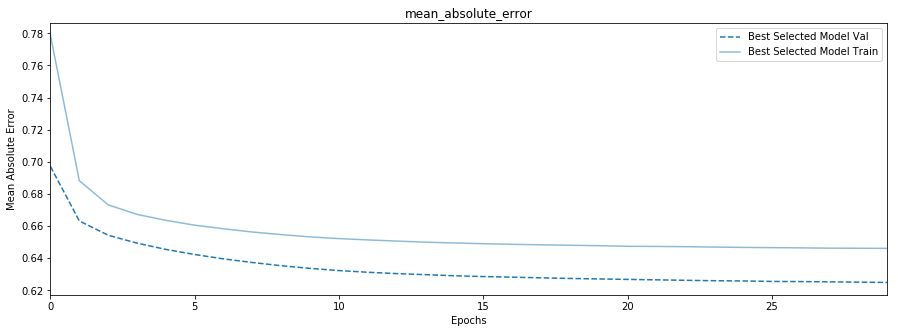

In [11]:
plot_history([ 
    ('best selected model', history_bestmodel),
])

In [86]:
# Use the recommend() function you wrote earlier to get the 5 best recommended movies
# for user 26556, and assign them to the variable l2_reccs.
l2_reccs = recommend(best_model, 26556)
l2_reccs

,movieId,title,genres,year,key,n_ratings,mean_rating,predicted_rating
1233,1233,Evil Dead II (Dead by Dawn),Action|Comedy|Fantasy|Horror,1987,Evil Dead II (Dead by Dawn),7788,3.772085,6.419149
2932,2932,Re-Animator,Comedy|Horror|Sci-Fi,1985,Re-Animator,1979,3.476503,6.205729
2374,2374,The Texas Chainsaw Massacre,Horror,1974,"Texas Chainsaw Massacre, The (1974)",3026,3.211335,6.200533
4438,4438,The Return of the Living Dead,Comedy|Horror|Sci-Fi,1985,The Return of the Living Dead,1081,3.369103,6.097945
1213,1213,Dead Alive (Braindead),Comedy|Fantasy|Horror,1992,Dead Alive (Braindead),2576,3.722632,6.045256


What do you think this model's predicted scores will look like for the 'obscure' movies that our earlier model highly recommended? 

Think about it, then run the cell below to see if you're right.

In [85]:
uid = 26556
obscure_reccs = recommend(model_MF, uid)
obscure_mids = obscure_reccs.index
preds = best_model.predict([
    np.repeat(uid, len(obscure_mids)),
    obscure_mids,
])
recc_df = movies_df.loc[obscure_mids].copy()
recc_df['l2_predicted_rating'] = preds + offset
recc_df

,movieId,title,genres,year,key,n_ratings,mean_rating,predicted_rating,l2_predicted_rating
1233,1233,Evil Dead II (Dead by Dawn),Action|Comedy|Fantasy|Horror,1987,Evil Dead II (Dead by Dawn),7788,3.772085,6.419149,4.284125
2932,2932,Re-Animator,Comedy|Horror|Sci-Fi,1985,Re-Animator,1979,3.476503,6.205729,4.156466
2374,2374,The Texas Chainsaw Massacre,Horror,1974,"Texas Chainsaw Massacre, The (1974)",3026,3.211335,6.200533,4.394135
4438,4438,The Return of the Living Dead,Comedy|Horror|Sci-Fi,1985,The Return of the Living Dead,1081,3.369103,6.097945,4.181310
1213,1213,Dead Alive (Braindead),Comedy|Fantasy|Horror,1992,Dead Alive (Braindead),2576,3.722632,6.045256,4.158440


In [95]:
best_model.save("best_model.h5")